In [586]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [587]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [10]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                     "parallax", 
                                                                                         "phot_g_mean_mag"])
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 22s, sys: 8.63 s, total: 1min 30s
Wall time: 1min 30s


In [12]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")
# ran at 451

CPU times: user 2.22 s, sys: 35.2 ms, total: 2.26 s
Wall time: 2.25 s


In [13]:
%%time
_all_sky_object = _all_sky_object.compute()

CPU times: user 1h 53min 43s, sys: 1h 43min 44s, total: 3h 37min 27s
Wall time: 1h 59min 53s


In [14]:
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [15]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 3min 3s, sys: 7.69 s, total: 3min 11s
Wall time: 3min 9s


In [16]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 4min 24s, sys: 6.47 s, total: 4min 30s
Wall time: 4min 30s


In [17]:
# lazy loading sources
_sources

,ra_gaia_,dec_gaia_,parallax_gaia_,parallax_over_error_gaia_,bp_rp_gaia_,solution_id_gaia_,source_id_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,parallax_error_gaia_,phot_g_mean_mag_gaia_,l_gaia_,b_gaia_,non_single_star_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,in_qso_candidates_gaia_,teff_gspphot_gaia_,teff_gspphot_upper_gaia_,teff_gspphot_lower_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Npix_,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [666]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43801 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43801/status,
Dashboard: http://127.0.0.1:43801/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43460,Workers: 12
Dashboard: http://127.0.0.1:43801/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:40677,Total threads: 8
Dashboard: http://127.0.0.1:46868/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:39935,


In [667]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Testing Functionalities

In [590]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density_async(131.1, 22.3)

CPU times: user 771 ms, sys: 475 ms, total: 1.25 s
Wall time: 1.09 s


{'closest_bright_star_arcsec': 0.0075408123219372295,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 0.0075408123219372295,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

In [594]:
%%time
# know dipper
lc = ens.source.loc[160477522780225536]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 31.9 s, sys: 13.2 s, total: 45.2 s
Wall time: 40.4 s


In [398]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)
time0, mag0, magerr0 = my_tools.fill_gaps(time, mag, magerr, num_points=25, max_gap_days=95, window_size=0)

In [399]:
import astropy.stats as astro_stats
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

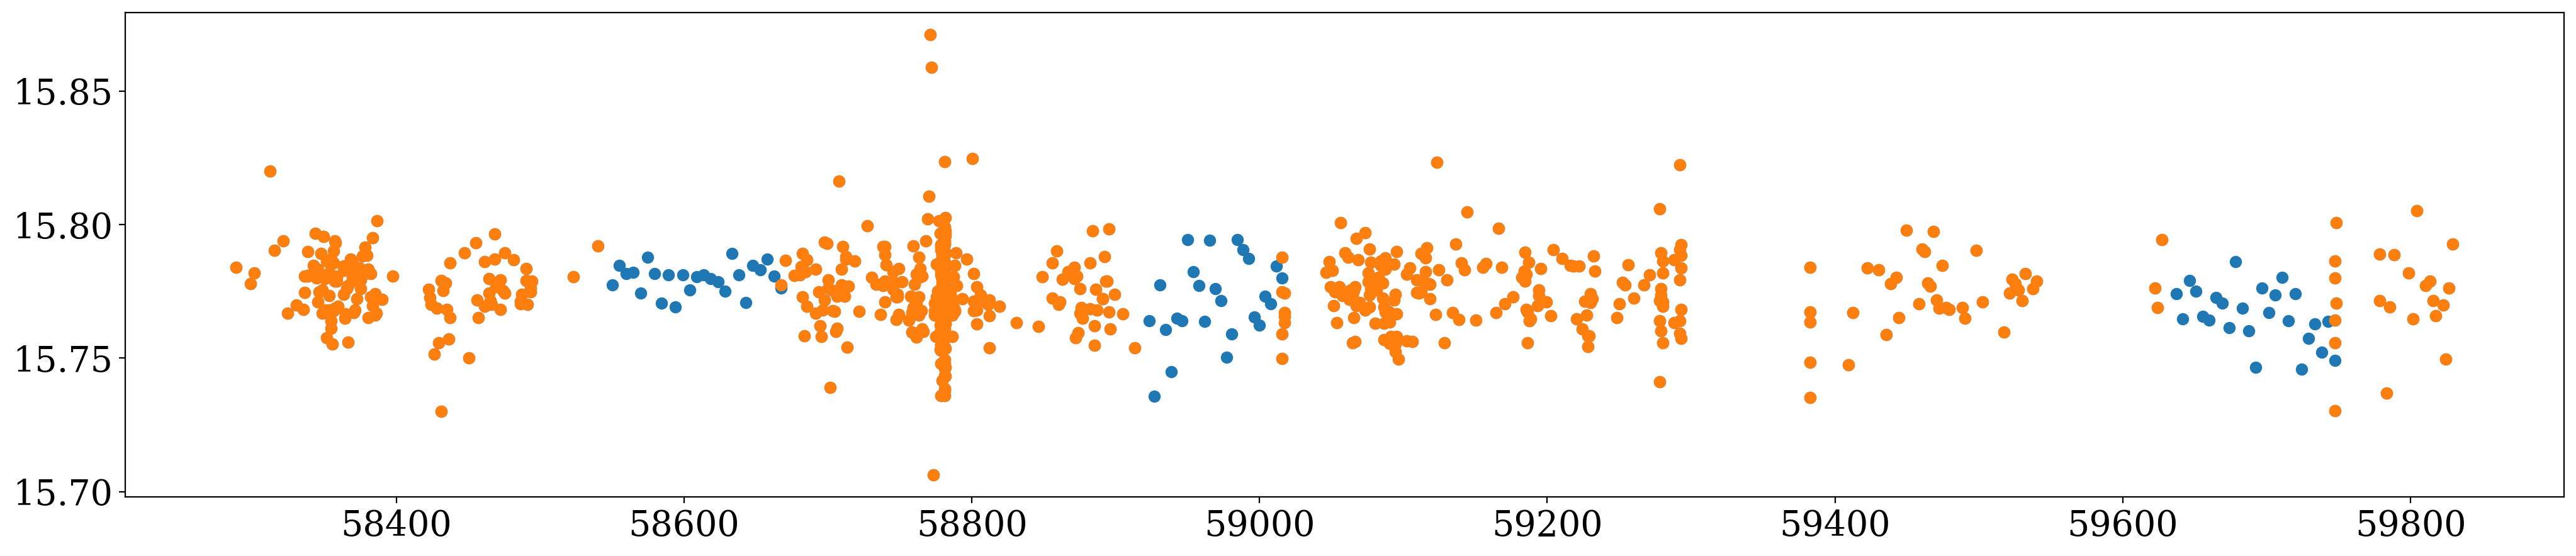

In [400]:
plt.figure(figsize=(25,5))
plt.scatter(time0, mag0)
plt.scatter(time, mag)


In [668]:
column_names = [
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2'
]

In [640]:
column_names[9::]

['best_dip_power',
 'best_dip_time_loc',
 'best_dip_start',
 'best_dip_end',
 'best_dip_dt',
 'best_dip_ndet',
 'best_dip_score',
 'left_error',
 'right_error',
 'chi_square_gp',
 'gp_fun',
 'gp_status',
 'separation_btw_peaks',
 'closest_bright_star_arcsec',
 'closest_bright_star_mag',
 'closest_star_arcsec',
 'closest_star_mag',
 'density_arcsec2']

In [681]:
## test
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

biweight_scale                1.234591e-02
frac_above_2_sigma            1.593625e-02
Ndips                         1.000000e+00
rate                          6.489428e-04
chi2dof                       1.000126e+00
ADF_const                    -2.508361e+01
ADF_const_trend              -2.521838e+01
ADF_pval_const                0.000000e+00
ADF_pval_const_trend          0.000000e+00
best_dip_power                5.635623e+00
best_dip_time_loc             5.877115e+04
best_dip_start                5.877414e+04
best_dip_end                  5.876516e+04
best_dip_dt                   9.915213e-01
best_dip_ndet                 9.000000e+00
best_dip_score                4.482542e+00
left_error                    0.000000e+00
right_error                   6.502533e+01
chi_square_gp                 7.811388e+02
gp_fun                        1.000000e+00
gp_status                     5.355550e-07
separation_btw_peaks         -1.982411e+01
closest_bright_star_arcsec    2.150917e-05
closest_bri

## Batch Calculation

In [669]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [670]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 'magerr_ztf_source', 'catflags_ztf_source','band_ztf_source', 'ra_ztf_source', 'dec_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 464 ms, sys: 43.8 ms, total: 508 ms
Wall time: 466 ms


In [647]:
for out in column_names:
    print (f"{out} = calc_['{out}'],")

biweight_scale = calc_['biweight_scale'],
frac_above_2_sigma = calc_['frac_above_2_sigma'],
Ndips = calc_['Ndips'],
rate = calc_['rate'],
chi2dof = calc_['chi2dof'],
ADF_const = calc_['ADF_const'],
ADF_const_trend = calc_['ADF_const_trend'],
ADF_pval_const = calc_['ADF_pval_const'],
ADF_pval_const_trend = calc_['ADF_pval_const_trend'],
best_dip_power = calc_['best_dip_power'],
best_dip_time_loc = calc_['best_dip_time_loc'],
best_dip_start = calc_['best_dip_start'],
best_dip_end = calc_['best_dip_end'],
best_dip_dt = calc_['best_dip_dt'],
best_dip_ndet = calc_['best_dip_ndet'],
best_dip_score = calc_['best_dip_score'],
left_error = calc_['left_error'],
right_error = calc_['right_error'],
chi_square_gp = calc_['chi_square_gp'],
gp_fun = calc_['gp_fun'],
gp_status = calc_['gp_status'],
separation_btw_peaks = calc_['separation_btw_peaks'],
closest_bright_star_arcsec = calc_['closest_bright_star_arcsec'],
closest_bright_star_mag = calc_['closest_bright_star_mag'],
closest_star_arcsec = calc

In [671]:
%%time
ens.assign(table='object',
          biweight_scale = calc_['biweight_scale'],
            frac_above_2_sigma = calc_['frac_above_2_sigma'],
            Ndips = calc_['Ndips'],
            rate = calc_['rate'],
            chi2dof = calc_['chi2dof'],
            ADF_const = calc_['ADF_const'],
            ADF_const_trend = calc_['ADF_const_trend'],
            ADF_pval_const = calc_['ADF_pval_const'],
            ADF_pval_const_trend = calc_['ADF_pval_const_trend'],
            best_dip_power = calc_['best_dip_power'],
            best_dip_time_loc = calc_['best_dip_time_loc'],
            best_dip_start = calc_['best_dip_start'],
            best_dip_end = calc_['best_dip_end'],
            best_dip_dt = calc_['best_dip_dt'],
            best_dip_ndet = calc_['best_dip_ndet'],
            best_dip_score = calc_['best_dip_score'],
            left_error = calc_['left_error'],
            right_error = calc_['right_error'],
            chi_square_gp = calc_['chi_square_gp'],
            gp_fun = calc_['gp_fun'],
            gp_status = calc_['gp_status'],
            separation_btw_peaks = calc_['separation_btw_peaks'],
            closest_bright_star_arcsec = calc_['closest_bright_star_arcsec'],
            closest_bright_star_mag = calc_['closest_bright_star_mag'],
            closest_star_arcsec = calc_['closest_star_arcsec'],
            closest_star_mag = calc_['closest_star_mag'],
            density_arcsec2 = calc_['density_arcsec2'])

CPU times: user 1min 39s, sys: 16 s, total: 1min 55s
Wall time: 1min 45s


In [708]:
%%time
t = ens.object.head(20_000, npartitions=2_500)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 48.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-01-08 22:29:29,171 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-be4a1171d695ab6bf6090b5be3574ef8', 535)
Function:  subgraph_callable-8f70b8e9-48be-40e4-8027-e031ab54
args:      ('TapeSourceFrame-e0443c7afc5ad52b18dee1c75167660f', 'from-delayed-0baa30d6ca72cfdb502d6dc91169aec3',                      ra_gaia_  dec_gaia_  ...  Dir_ztf_source  Npix_ztf_source
_hipscat_index                            ...                                 
114711714750005248  54.424403  19.951346  ...               0             1630
114711714750005248  54.424403  19.951346  ...               0             1630
114711714750005248  54.424403  19.951346  ...               0             1630
114711714750005248  54.424403  19

MissingDataError: exog contains inf or nans

In [694]:
%%time
lc = ens.source.loc[307379438616576].compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 18.5 s, sys: 5.62 s, total: 24.1 s
Wall time: 20 s


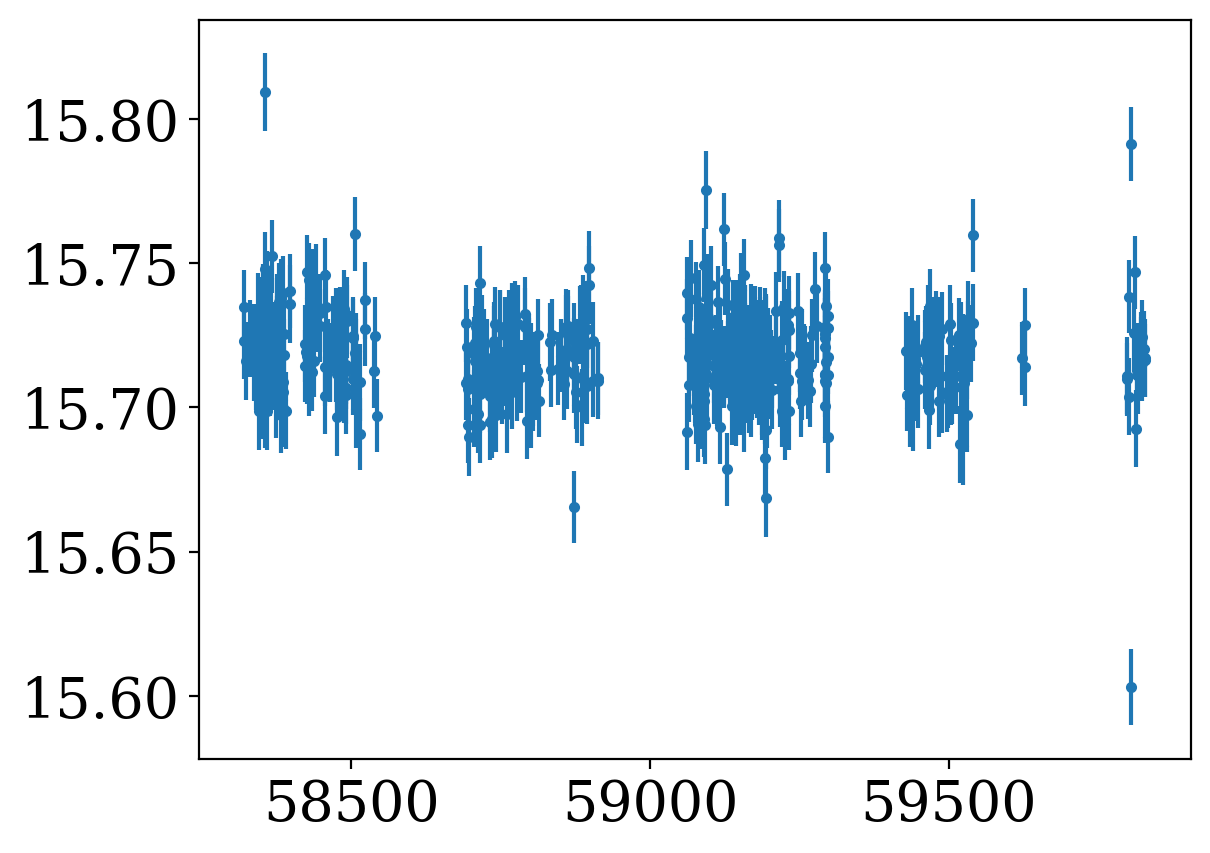

In [698]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)
plt.errorbar(time, mag, magerr, fmt='.')

time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=25, max_gap_days=95, window_size=0)

(15.83444718751125, 15.578194396430627)

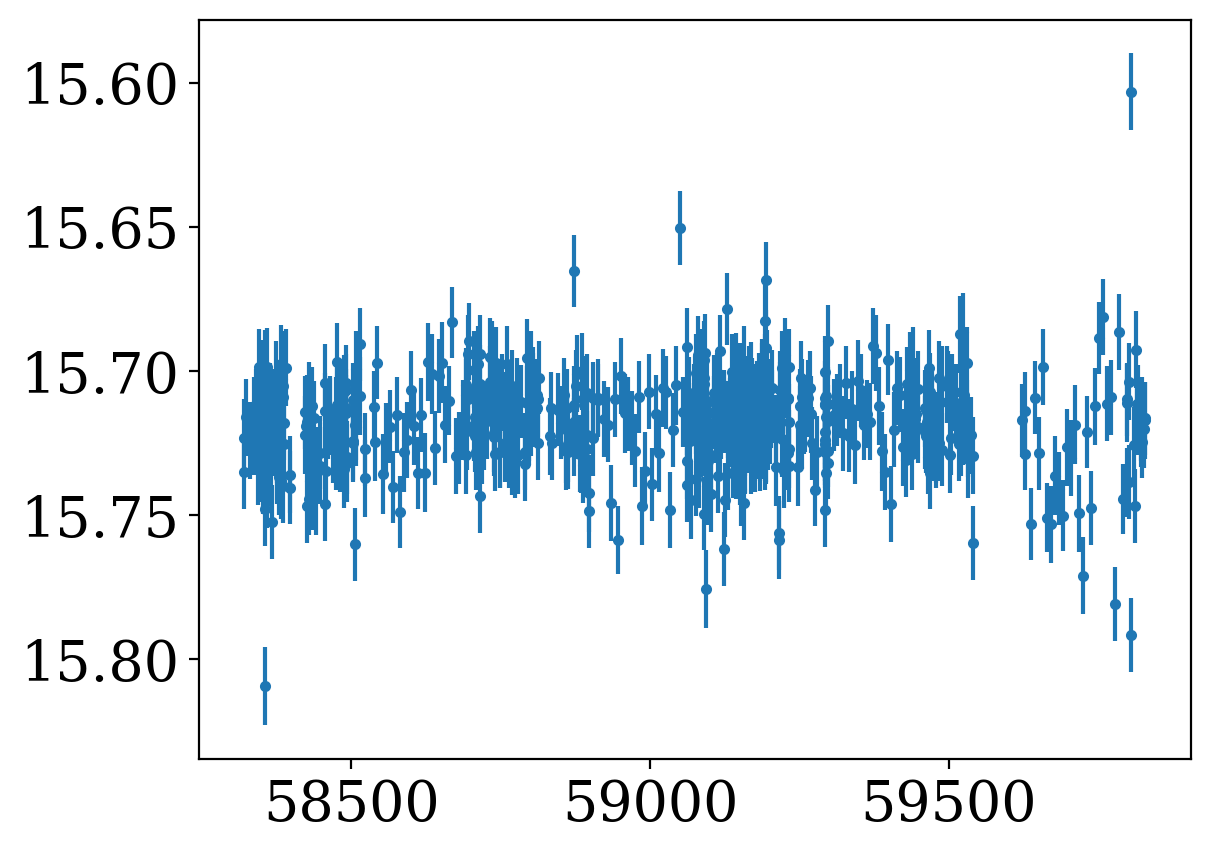

In [699]:
plt.errorbar(time, mag, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])

In [564]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

In [565]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=5,  peak_close_rmv=15, pk_2_pk_cut=250)

# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

No dip is found within the minimum number of detections.


In [574]:
from tqdm import tqdm

In [582]:
ids = _sample_hips._ddf.head(100, npartitions=30).index

In [584]:
len(ids)

100

In [585]:
for i in tqdm(ids[22::]):
    lc = ens.source.loc[i].compute()    
    print (evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], 
        lc['dec_ztf_source']))

  0%|          | 0/78 [00:00<?, ?it/s]/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  1%|▏         | 1/78 [00:20<26:22, 20.55s/it]

REJECTING!
biweight_scale                0.017742
frac_above_2_sigma            0.017804
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  3%|▎         | 2/78 [00:38<24:09, 19.08s/it]

REJECTING!
biweight_scale                0.017899
frac_above_2_sigma            0.038043
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  4%|▍         | 3/78 [00:55<22:33, 18.05s/it]

REJECTING!
biweight_scale                0.019407
frac_above_2_sigma            0.035011
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  5%|▌         | 4/78 [01:12<21:57, 17.81s/it]

REJECTING!
biweight_scale                0.022928
frac_above_2_sigma            0.040816
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
  6%|▋         | 5/78 [01:28<20:53, 17.17s/it]

biweight_scale                0.014570
frac_above_2_sigma            0.035881
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:26:46,008 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
  8%|▊         | 6/78 [02:00<26:33, 22.13s/it]

biweight_scale                0.012452
frac_above_2_sigma            0.024730
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
  9%|▉         | 7/78 [02:16<23:41, 20.02s/it]

biweight_scale                0.013166
frac_above_2_sigma            0.023148
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 10%|█         | 8/78 [02:33<22:22, 19.18s/it]

biweight_scale                0.015579
frac_above_2_sigma            0.018547
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 12%|█▏        | 9/78 [02:52<21:59, 19.13s/it]

biweight_scale                0.015470
frac_above_2_sigma            0.026471
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 13%|█▎        | 10/78 [03:11<21:38, 19.10s/it]

REJECTING!
biweight_scale                0.014920
frac_above_2_sigma            0.024691
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 14%|█▍        | 11/78 [03:28<20:36, 18.46s/it]

biweight_scale                0.020292
frac_above_2_sigma            0.049096
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:28:46,048 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 15%|█▌        | 12/78 [04:01<25:02, 22.77s/it]

REJECTING!
biweight_scale                0.012377
frac_above_2_sigma            0.020619
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 17%|█▋        | 13/78 [04:18<22:43, 20.98s/it]

REJECTING!
biweight_scale                0.014368
frac_above_2_sigma            0.020619
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 14/78 [04:36<21:30, 20.16s/it]

REJECTING!
biweight_scale                0.012135
frac_above_2_sigma            0.020619
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 19%|█▉        | 15/78 [04:52<19:45, 18.82s/it]

REJECTING!
biweight_scale                0.012979
frac_above_2_sigma            0.033505
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 21%|██        | 16/78 [05:09<18:50, 18.23s/it]

REJECTING!
biweight_scale                0.014913
frac_above_2_sigma            0.025773
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 17/78 [05:26<18:11, 17.89s/it]

REJECTING!
biweight_scale                0.012369
frac_above_2_sigma            0.015464
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:30:40,835 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 23%|██▎       | 18/78 [05:58<22:09, 22.16s/it]

biweight_scale                0.015798
frac_above_2_sigma            0.028302
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 19/78 [06:13<19:46, 20.11s/it]

REJECTING!
biweight_scale                0.014344
frac_above_2_sigma            0.038860
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 26%|██▌       | 20/78 [06:29<18:08, 18.77s/it]

REJECTING!
biweight_scale                0.012949
frac_above_2_sigma            0.040816
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 21/78 [06:45<17:09, 18.06s/it]

REJECTING!
biweight_scale                0.010998
frac_above_2_sigma            0.000000
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 28%|██▊       | 22/78 [07:00<15:48, 16.94s/it]

REJECTING!
biweight_scale                0.013367
frac_above_2_sigma            0.010204
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 29%|██▉       | 23/78 [07:16<15:20, 16.74s/it]

REJECTING!
biweight_scale                0.015309
frac_above_2_sigma            0.023499
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:32:34,339 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 24/78 [07:53<20:31, 22.80s/it]

REJECTING!
biweight_scale                0.016873
frac_above_2_sigma            0.025907
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 32%|███▏      | 25/78 [08:09<18:21, 20.78s/it]

REJECTING!
biweight_scale                0.012267
frac_above_2_sigma            0.010204
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 26/78 [08:28<17:36, 20.31s/it]

REJECTING!
biweight_scale                0.008672
frac_above_2_sigma            0.020833
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 35%|███▍      | 27/78 [08:44<16:06, 18.95s/it]

biweight_scale                0.015513
frac_above_2_sigma            0.023529
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 36%|███▌      | 28/78 [09:00<15:07, 18.15s/it]

REJECTING!
biweight_scale                0.014925
frac_above_2_sigma            0.023256
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 29/78 [09:17<14:24, 17.64s/it]

REJECTING!
biweight_scale                0.014302
frac_above_2_sigma            0.028351
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:34:30,066 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 38%|███▊      | 30/78 [09:46<17:02, 21.31s/it]

REJECTING!
biweight_scale                0.016226
frac_above_2_sigma            0.020672
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 40%|███▉      | 31/78 [10:03<15:36, 19.92s/it]

REJECTING!
biweight_scale                0.015476
frac_above_2_sigma            0.030612
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 41%|████      | 32/78 [10:20<14:33, 18.99s/it]

biweight_scale                0.022472
frac_above_2_sigma            0.014451
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 42%|████▏     | 33/78 [10:39<14:14, 19.00s/it]

REJECTING!
biweight_scale                0.011596
frac_above_2_sigma            0.021978
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 44%|████▎     | 34/78 [10:57<13:42, 18.69s/it]

biweight_scale                0.011563
frac_above_2_sigma            0.030905
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 45%|████▍     | 35/78 [11:14<12:57, 18.09s/it]

biweight_scale                0.016239
frac_above_2_sigma            0.032558
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:36:25,950 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 46%|████▌     | 36/78 [11:43<15:02, 21.49s/it]

biweight_scale                0.017305
frac_above_2_sigma            0.020155
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 47%|████▋     | 37/78 [11:59<13:31, 19.80s/it]

biweight_scale                0.014259
frac_above_2_sigma            0.024806
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 49%|████▊     | 38/78 [12:20<13:25, 20.15s/it]

biweight_scale                0.014189
frac_above_2_sigma            0.029827
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 50%|█████     | 39/78 [12:39<12:56, 19.91s/it]

biweight_scale                0.014233
frac_above_2_sigma            0.032609
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 51%|█████▏    | 40/78 [12:55<11:50, 18.70s/it]

biweight_scale                0.018873
frac_above_2_sigma            0.035874
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 53%|█████▎    | 41/78 [13:11<11:02, 17.91s/it]

biweight_scale                0.021944
frac_above_2_sigma            0.015504
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:38:24,950 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 54%|█████▍    | 42/78 [13:41<12:58, 21.63s/it]

biweight_scale                0.018814
frac_above_2_sigma            0.034301
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 43/78 [13:57<11:31, 19.77s/it]

REJECTING!
biweight_scale                0.021644
frac_above_2_sigma            0.026385
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 56%|█████▋    | 44/78 [14:13<10:32, 18.62s/it]

biweight_scale                0.021100
frac_above_2_sigma            0.023438
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 58%|█████▊    | 45/78 [14:28<09:37, 17.50s/it]

REJECTING!
biweight_scale                0.014019
frac_above_2_sigma            0.026627
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 59%|█████▉    | 46/78 [14:42<08:53, 16.66s/it]

biweight_scale                0.016265
frac_above_2_sigma            0.036364
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 60%|██████    | 47/78 [14:57<08:22, 16.19s/it]

biweight_scale                0.015495
frac_above_2_sigma            0.031250
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:40:10,172 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 62%|██████▏   | 48/78 [15:26<09:57, 19.91s/it]

biweight_scale                0.016735
frac_above_2_sigma            0.031169
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 63%|██████▎   | 49/78 [15:43<09:13, 19.09s/it]

biweight_scale                0.020914
frac_above_2_sigma            0.024854
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 64%|██████▍   | 50/78 [16:01<08:44, 18.72s/it]

biweight_scale                0.014443
frac_above_2_sigma            0.027182
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 51/78 [16:17<08:00, 17.79s/it]

REJECTING!
biweight_scale                0.015389
frac_above_2_sigma            0.018182
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 67%|██████▋   | 52/78 [16:31<07:17, 16.82s/it]

biweight_scale                0.014978
frac_above_2_sigma            0.037810
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

2024-01-05 16:41:59,207 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 68%|██████▊   | 53/78 [17:06<09:13, 22.15s/it]

biweight_scale                0.014917
frac_above_2_sigma            0.023377
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 54/78 [17:22<08:07, 20.31s/it]

REJECTING!
biweight_scale                0.012771
frac_above_2_sigma            0.031169
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 71%|███████   | 55/78 [17:40<07:34, 19.74s/it]

biweight_scale                0.018126
frac_above_2_sigma            0.012987
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 72%|███████▏  | 56/78 [17:58<07:00, 19.10s/it]

REJECTING!
biweight_scale                0.016884
frac_above_2_sigma            0.020779
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 57/78 [18:15<06:26, 18.42s/it]

REJECTING!
biweight_scale                0.022368
frac_above_2_sigma            0.020779
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 74%|███████▍  | 58/78 [18:31<05:55, 17.79s/it]

REJECTING!
biweight_scale                0.012551
frac_above_2_sigma            0.031250
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:43:52,954 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 76%|███████▌  | 59/78 [19:00<06:39, 21.05s/it]

biweight_scale                0.014198
frac_above_2_sigma            0.028571
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 77%|███████▋  | 60/78 [19:17<05:58, 19.94s/it]

REJECTING!
biweight_scale                0.015173
frac_above_2_sigma            0.028571
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 78%|███████▊  | 61/78 [19:33<05:18, 18.72s/it]

biweight_scale                0.012587
frac_above_2_sigma            0.031169
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 79%|███████▉  | 62/78 [19:48<04:42, 17.63s/it]

biweight_scale                0.014097
frac_above_2_sigma            0.038860
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 81%|████████  | 63/78 [20:04<04:15, 17.01s/it]

biweight_scale                0.014524
frac_above_2_sigma            0.005195
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 64/78 [20:20<03:57, 16.95s/it]

REJECTING!
biweight_scale                0.014067
frac_above_2_sigma            0.031088
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:45:51,018 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 83%|████████▎ | 65/78 [21:01<05:12, 24.03s/it]

biweight_scale                0.020746
frac_above_2_sigma            0.023316
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 85%|████████▍ | 66/78 [21:19<04:28, 22.38s/it]

biweight_scale                0.017264
frac_above_2_sigma            0.020725
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 86%|████████▌ | 67/78 [21:38<03:52, 21.12s/it]

REJECTING!
biweight_scale                0.015044
frac_above_2_sigma            0.018135
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 87%|████████▋ | 68/78 [21:57<03:25, 20.59s/it]

REJECTING!
biweight_scale                0.014903
frac_above_2_sigma            0.041420
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 69/78 [22:15<02:57, 19.69s/it]

REJECTING!
biweight_scale                0.014826
frac_above_2_sigma            0.023810
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 70/78 [22:32<02:31, 18.98s/it]

REJECTING!
biweight_scale                0.015249
frac_above_2_sigma            0.032544
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:47:59,126 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 91%|█████████ | 71/78 [23:08<02:49, 24.20s/it]

REJECTING!
biweight_scale                0.162231
frac_above_2_sigma            0.019920
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 72/78 [23:26<02:13, 22.28s/it]

REJECTING!
biweight_scale                0.017681
frac_above_2_sigma            0.028497
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▎| 73/78 [23:44<01:45, 21.01s/it]

REJECTING!
biweight_scale                0.016399
frac_above_2_sigma            0.040214
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
 95%|█████████▍| 74/78 [24:01<01:19, 19.75s/it]

biweight_scale                0.016073
frac_above_2_sigma            0.007958
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 75/78 [24:20<00:58, 19.57s/it]

REJECTING!
biweight_scale                0.013162
frac_above_2_sigma            0.030848
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 97%|█████████▋| 76/78 [24:38<00:37, 18.99s/it]

REJECTING!
biweight_scale                0.011791
frac_above_2_sigma            0.030612
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

2024-01-05 16:50:00,883 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 99%|█████████▊| 77/78 [25:10<00:22, 22.88s/it]

REJECTING!
biweight_scale                0.018259
frac_above_2_sigma            0.020408
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median      

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
100%|██████████| 78/78 [25:29<00:00, 19.61s/it]

biweight_scale                0.016737
frac_above_2_sigma            0.034121
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

In [573]:
## test
print (evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], 
        lc['dec_ztf_source']))

biweight_scale                0.015657
frac_above_2_sigma            0.019694
Ndips                         0.000000
rate                          0.000000
best_dip_power                     NaN
best_dip_time_loc                  NaN
best_dip_start                     NaN
best_dip_end                       NaN
best_dip_dt                        NaN
best_dip_ndet                      NaN
best_dip_score                     NaN
left_error                         NaN
right_error                        NaN
log_sum_error                      NaN
logL_best_dip                      NaN
amp_median                         NaN
amp_std                            NaN
location_median                    NaN
location_std                       NaN
sigma_median                       NaN
sigma_std                          NaN
log_sigma2_median                  NaN
log_sigma2_std                     NaN
m_median                           NaN
m_std                              NaN
b_median                 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))


In [ ]:
%%time
example = ens.object.head(4_833_834, npartitions=287_241)
# ran at 1:10am jan 5

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 2.65 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
